## Contents<a id='3.1_Contents'></a>
* [1 Image Augmentation](#1-Image-Augmentation)
  * [1.1 Introduction](#1.1-Introduction)
  * [1.2 Imports](#1.2-Imports)
  * [1.3 Inspecting the images](#1.3-Inspecting-the-images)
  * [1.4 Applying rotation and flipping](#1.4-Applying-rotation-and-flipping)
  * [1.5 Calibrating the brightness](#1.5-Calibrating-the-brightness)
  * [1.6 Image sharpening](#1.6-Image-sharpening)
  * [1.7 Edge detection applying Sobel](#1.7-Edge-detection-applying-Sobel)
  * [1.8 X-ray effect](#1.8-X-ray-effect)
  * [1.9 Applying enhancements to the dataset](#1.9-Applying-enhancements-to-the-dataset)
  * [1.10 Concatenating the datasets](#1.10-Concatenating-the-datasets)

# 1.1 Introduction

In this notebook we will view some of the images. As we do not have much data, we will apply augmentation to the images to make the model more generalize on the the dataset. We will work on the grayscale version of the images.

# 1.2 Imports

In [42]:
import os
import glob
import numpy as np
import cv2

from skimage import data, color, filters, measure, exposure, morphology

from skimage.filters import sobel
from skimage.segmentation import slic
from skimage.color import label2rgb

import imageio.v2 as imageio

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split

import shutil

# 1.3 Inspecting the images

In [2]:
def show_image(image, title='Image', cmap_type='gray'):
    '''Displays an image using matplotlib, with optional title and color mapping.'''
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

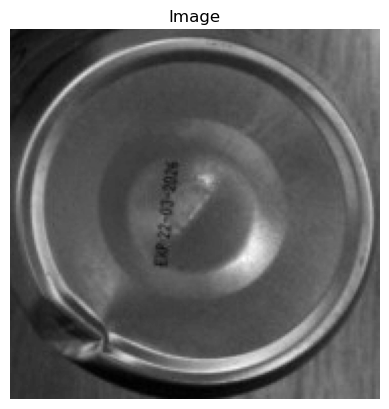

In [3]:
img = mpimg.imread('../data/processed/cropped_lids/p9_449_252_damaged.jpg')
gray = color.rgb2gray(img)
show_image(gray)

# 1.4 Applying rotation and flipping

First, we will apply rotation and flip on the images to make the dataset more generalize.

In [8]:
# Original image folder
input_dir = r"/mnt/d/Github repository/SpringboardCapstoneThree/data/processed/cropped_lids"

# Output folder for augmented images
output_dir = os.path.join(input_dir, "augmented")
os.makedirs(output_dir, exist_ok=True)

In [9]:
def augment_and_save(image_path):
    '''This function performs basic image augmentation operations like rotation and flipping on a given image.'''
    try:
        img = Image.open(image_path)
        base_name = os.path.splitext(os.path.basename(image_path))[0]

        # Rotating +35°
        img.rotate(35, expand=True).save(os.path.join(output_dir, f"{base_name}_rot35.jpg"))

        # Rotating -35°
        img.rotate(-35, expand=True).save(os.path.join(output_dir, f"{base_name}_rot-35.jpg"))

        # 90°
        img.rotate(90, expand=True).save(os.path.join(output_dir, f"{base_name}_rot90.jpg"))

        # Horizontal flip
        ImageOps.mirror(img).save(os.path.join(output_dir, f"{base_name}_flip.jpg"))
        
    except Exception as e:
        print(f"Failed to process {image_path}: {e}")

In [10]:
all_images = glob.glob(os.path.join(input_dir, "*.jpg"))

print(f"Found {len(all_images)} images. Starting augmentation...")

for image_path in all_images:
    augment_and_save(image_path)

print("Done! Augmented images saved to:", output_dir)

Found 1859 images. Starting augmentation...
Done! Augmented images saved to: /mnt/d/Github repository/SpringboardCapstoneThree/data/processed/cropped_lids/augmented


# 1.5 Calibrating the brightness

In this step, we will tweak the brightness a bit. Our purpose is to make the model more capable of handling different lighting situations. Also, we will done so in a manner so that it helps the model in the classification process. 

#### Making the images a bit darker

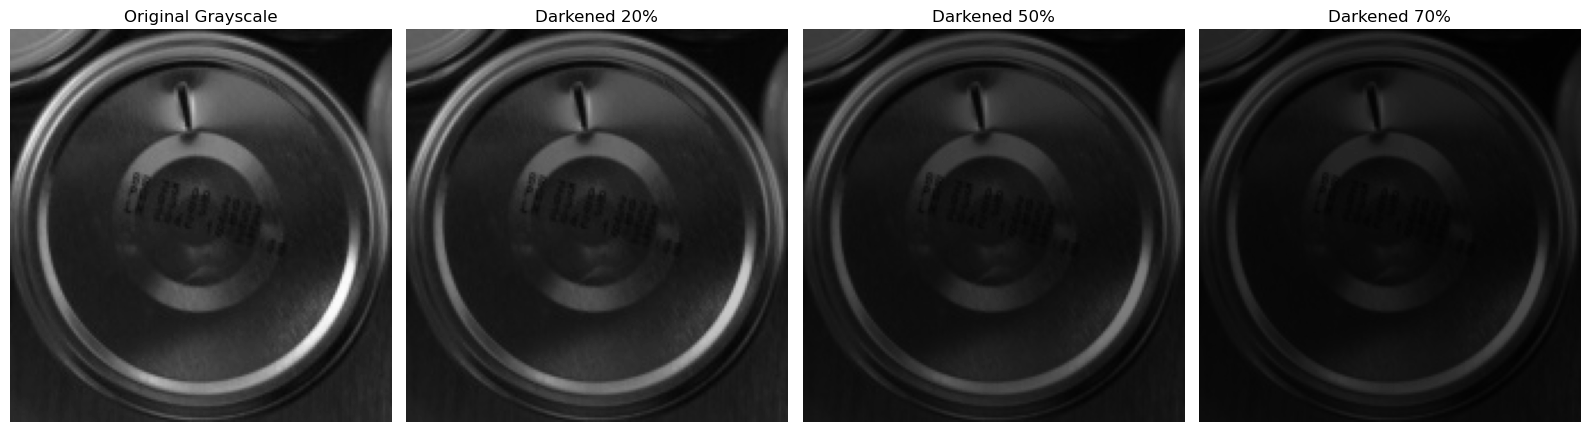

In [15]:
# Loading and converting to grayscale
img = mpimg.imread('../data/processed/cropped_lids/p4_266_304_damaged.jpg')
gray = color.rgb2gray(img)

# Applying darken effects
darker_80 = gray * 0.8   # 20% darkened
darker_30 = gray * 0.3   # 70% darkened 
darker_50 = gray * 0.5   # 50% darkened 

# Ensuring all values are still in range [0, 1]
darker_80 = np.clip(darker_80, 0, 1)
darker_50 = np.clip(darker_50, 0, 1)
darker_30 = np.clip(darker_30, 0, 1)

# Displaying all images in a row
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

axs[0].imshow(gray, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Grayscale')
axs[0].axis('off')

axs[1].imshow(darker_80, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Darkened 20%')

axs[2].imshow(darker_50, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Darkened 50%')

axs[3].imshow(darker_30, cmap='gray', vmin=0, vmax=1)
axs[3].set_title('Darkened 70%')

# Removing axis ticks for all
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

We will choose the 20% darkened effect. A much darker image is no good to the machine learing model.

#### A slight brighter version

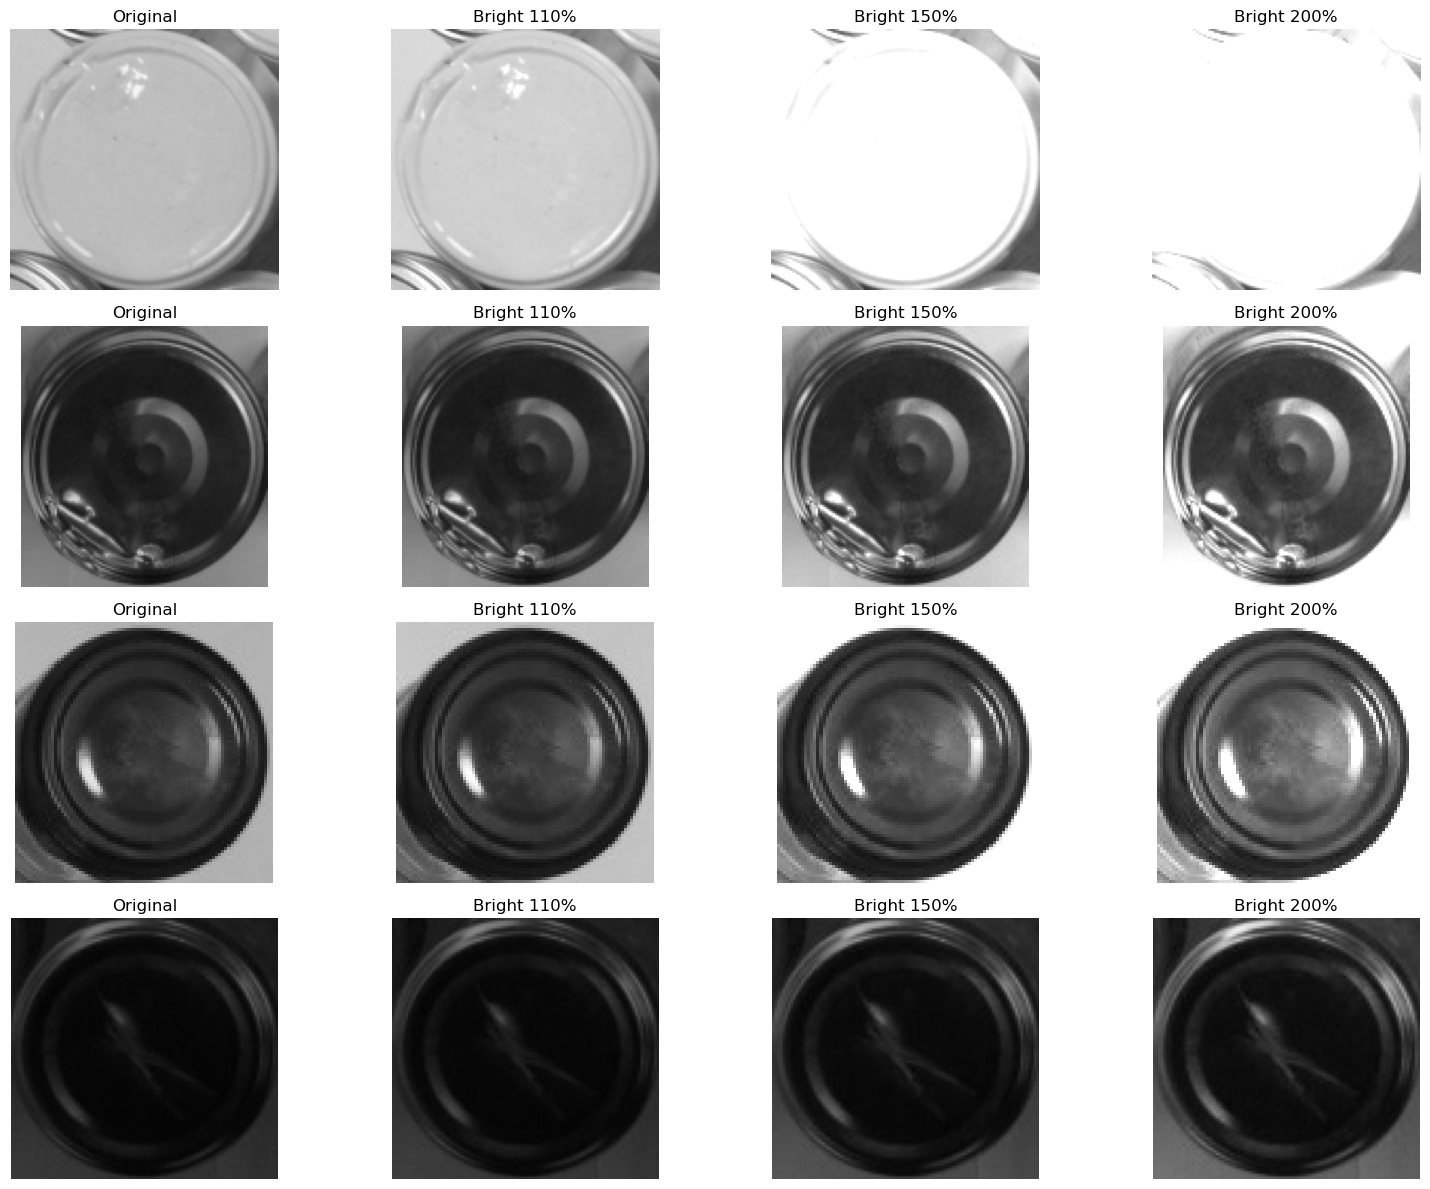

In [18]:
# Load images
image_paths = [
    '../data/processed/cropped_lids/p71_81_100_damaged.jpg',
    '../data/processed/cropped_lids/p86_280_294_damaged.jpg',
    '../data/processed/cropped_lids/p89_526_49_intact.jpg',
    '../data/processed/cropped_lids/p104_146_337_damaged.jpg'
]

# Preparing plot: 4 rows, 4 columns
fig, axs = plt.subplots(len(image_paths), 4, figsize=(16, 12))

for idx, path in enumerate(image_paths):
    img = mpimg.imread(path)
    gray = color.rgb2gray(img)

    # Brightening effects
    brighter_1 = np.clip(gray * 1.1, 0, 1)
    brighter_1_5 = np.clip(gray * 1.5, 0, 1)
    brighter_2 = np.clip(gray * 2.0, 0, 1)

    # Plotting
    axs[idx][0].imshow(gray, cmap='gray', vmin=0, vmax=1)
    axs[idx][0].set_title('Original')
    axs[idx][0].axis('off')

    axs[idx][1].imshow(brighter_1, cmap='gray', vmin=0, vmax=1)
    axs[idx][1].set_title('Bright 110%')
    axs[idx][1].axis('off')

    axs[idx][2].imshow(brighter_1_5, cmap='gray', vmin=0, vmax=1)
    axs[idx][2].set_title('Bright 150%')
    axs[idx][2].axis('off')

    axs[idx][3].imshow(brighter_2, cmap='gray', vmin=0, vmax=1)
    axs[idx][3].set_title('Bright 200%')
    axs[idx][3].axis('off')

plt.tight_layout()
plt.show()

We will consider the 150% brightening effect. Seems it will be a better fit. Though for the white lids, it seems, it will not be of much use. But for the other types of jar lids, it could be beneficial.

# 1.6 Image sharpening

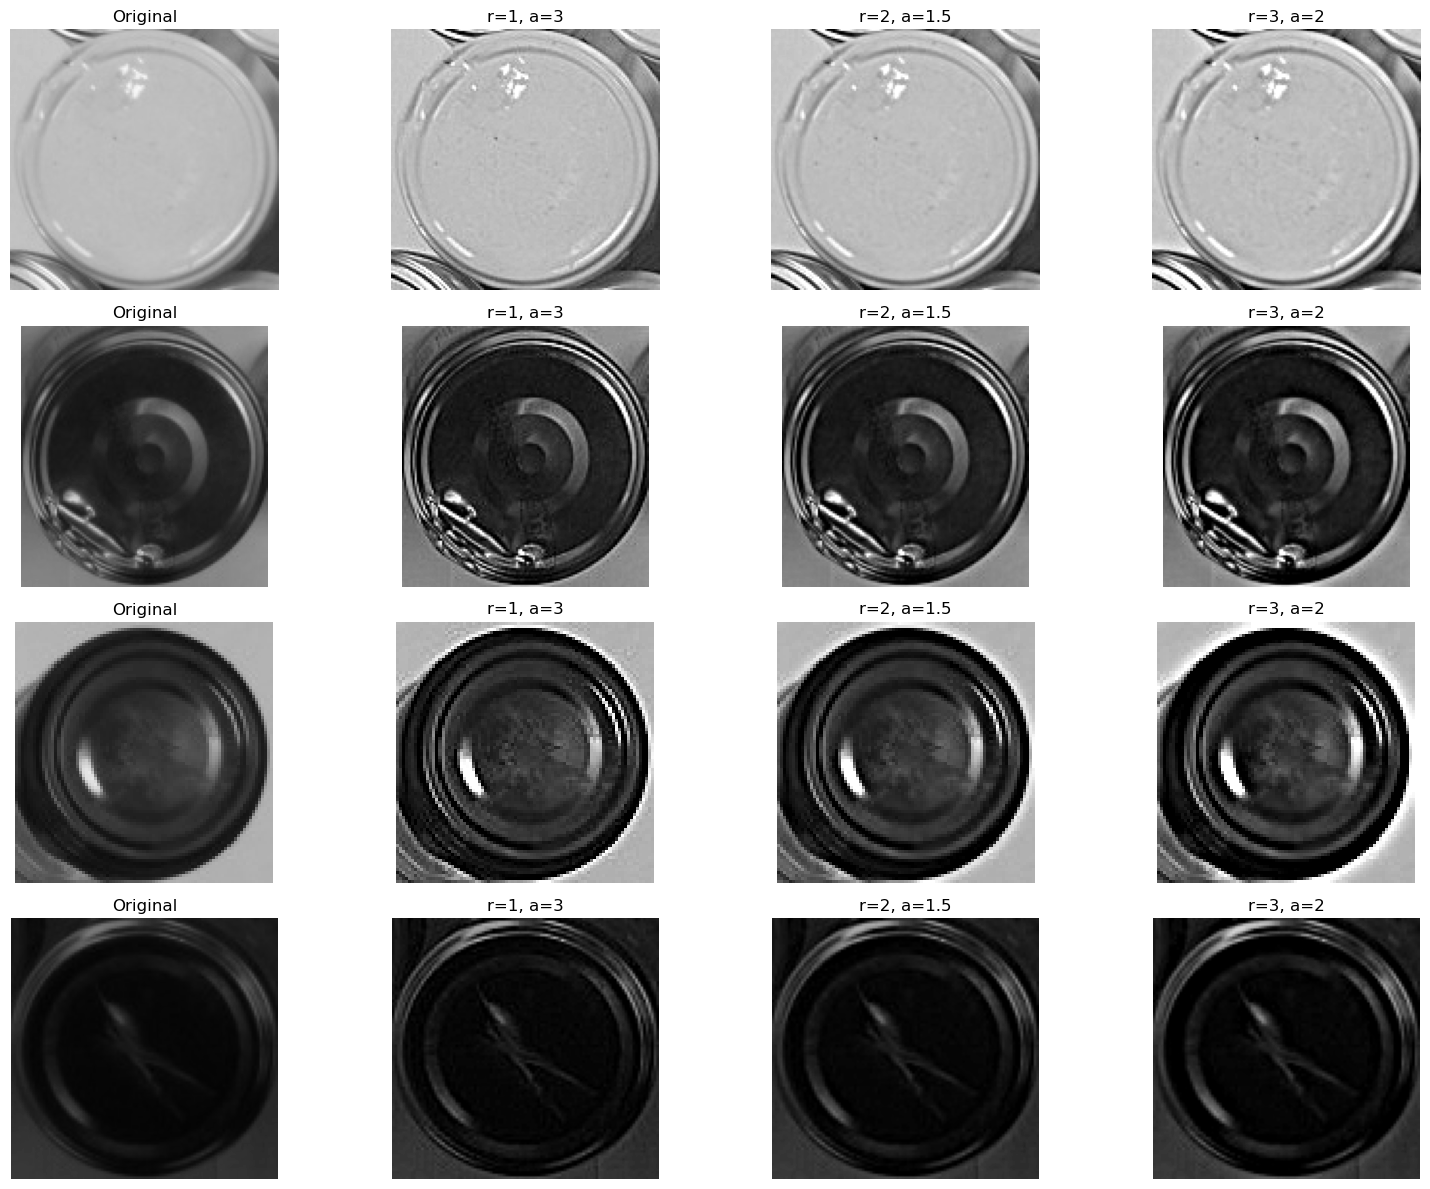

In [21]:
# Load images
image_paths = [
    '../data/processed/cropped_lids/p71_81_100_damaged.jpg',
    '../data/processed/cropped_lids/p86_280_294_damaged.jpg',
    '../data/processed/cropped_lids/p89_526_49_intact.jpg',
    '../data/processed/cropped_lids/p104_146_337_damaged.jpg'
]

# Preparing plot: 4 rows, 4 columns
fig, axs = plt.subplots(len(image_paths), 4, figsize=(16, 12))

for idx, path in enumerate(image_paths):
    img = mpimg.imread(path)
    gray = color.rgb2gray(img)

    # Applying unsharp masking with different parameters
    sharpened_1 = filters.unsharp_mask(gray, radius=1, amount=3)
    sharpened_2 = filters.unsharp_mask(gray, radius=2, amount=1.5)
    sharpened_3 = filters.unsharp_mask(gray, radius=3, amount=2)

    # Plotting
    axs[idx][0].imshow(gray, cmap='gray', vmin=0, vmax=1)
    axs[idx][0].set_title('Original')
    axs[idx][0].axis('off')

    axs[idx][1].imshow(sharpened_1, cmap='gray', vmin=0, vmax=1)
    axs[idx][1].set_title('r=1, a=3')
    axs[idx][1].axis('off')

    axs[idx][2].imshow(sharpened_2, cmap='gray', vmin=0, vmax=1)
    axs[idx][2].set_title('r=2, a=1.5')
    axs[idx][2].axis('off')

    axs[idx][3].imshow(sharpened_3, cmap='gray', vmin=0, vmax=1)
    axs[idx][3].set_title('r=3, a=2')
    axs[idx][3].axis('off')

plt.tight_layout()
plt.show()

We will choose radius = 1 and amount = 3, as it seems more prominent.

# 1.7 Edge detection applying Sobel

### Introduction to Sobel Filter

The **Sobel filter** is a classic edge detection technique used in image processing and computer vision. It works by highlighting areas of **high spatial gradient**—in simpler terms, regions in the image where pixel intensity changes rapidly. These changes often correspond to **edges**, like the boundaries of objects.

Sobel uses a pair of **convolution kernels** (small matrices), one for detecting horizontal changes (`sobelx`) and one for vertical changes (`sobely`). When applied to an image, they calculate the gradient in each direction:

- `sobelx` detects vertical edges (i.e., changes along the x-axis)
- `sobely` detects horizontal edges (i.e., changes along the y-axis)

By combining these two gradients using the **Euclidean magnitude**, we get a final image that highlights all prominent edges, regardless of direction.

### Why Use Sobel?

- It's simple and fast.
- It reduces noise via a smoothing effect (unlike pure derivatives).
- It's great for emphasizing structural information (object boundaries, in our case defective regions).

### Technical Note:

The Sobel output is typically computed in `float64` precision (`CV_64F`) to preserve negative and high-magnitude gradients. Afterward, it's normalized to the 0–255 range and converted to `uint8` so we can view it as a standard image.

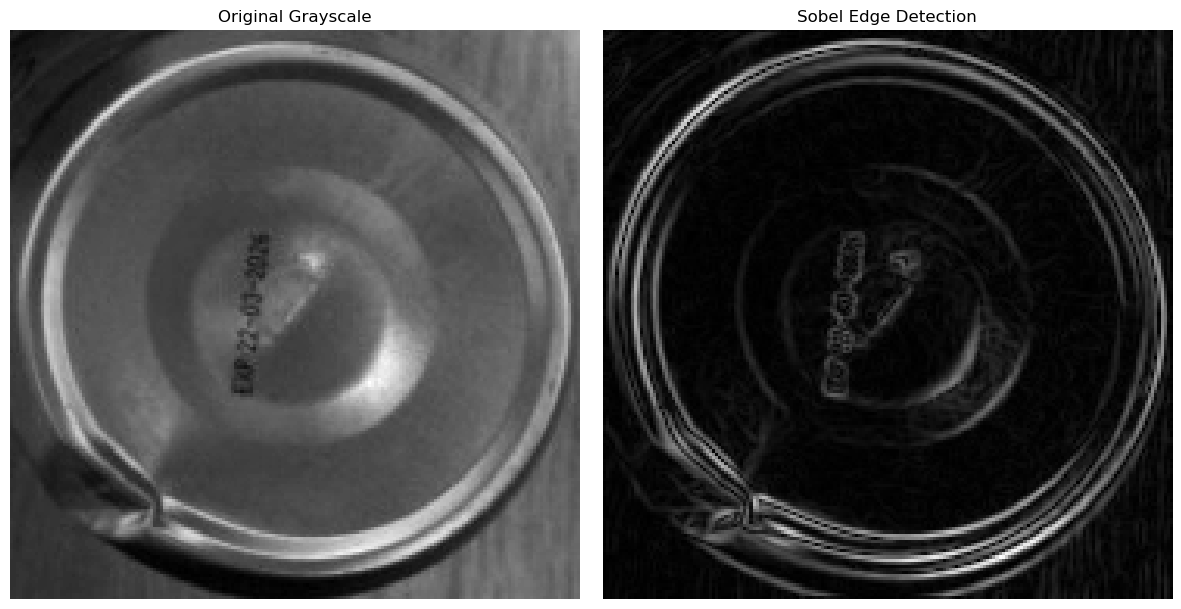

In [4]:
# Loading and converting to grayscale (float64 in range [0, 1])
img = mpimg.imread('../data/processed/cropped_lids/p9_449_252_damaged.jpg')
gray = color.rgb2gray(img)

# cv2.Sobel() wants a single-channel image in either uint8 or float32/float64 format
# Converting grayscale to 8-bit format (uint8 in range [0, 255])
img_gray = (gray * 255).astype(np.uint8)

# Applying Sobel Filter 
sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3) # 1,0 -- "computing horizontal gradient" # ksize=3 -- Use a 3x3 Sobel kernel
# cv2.CV_64F -- This is a flag in OpenCV that tells the cv2.Sobel() function what data type the output should be in.
# cv2.CV_64F -- Output will be in float64, preserving precision, to get accurate results with full decimal + negative range.
# As gradients can go negative (like -200) or exceed 255 (like 300), especially after convolution.

sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)  
edge = cv2.magnitude(sobelx, sobely)
edge = cv2.normalize(edge, None, 0, 255, cv2.NORM_MINMAX)
edge = edge.astype(np.uint8)

# Showing the result 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title("Original Grayscale")
axs[0].axis('off')

axs[1].imshow(edge, cmap='gray')
axs[1].set_title("Sobel Edge Detection")
axs[1].axis('off')

plt.tight_layout()
plt.show()

We will apply this edge detection technique to our original image. 

# 1.8 X-ray effect

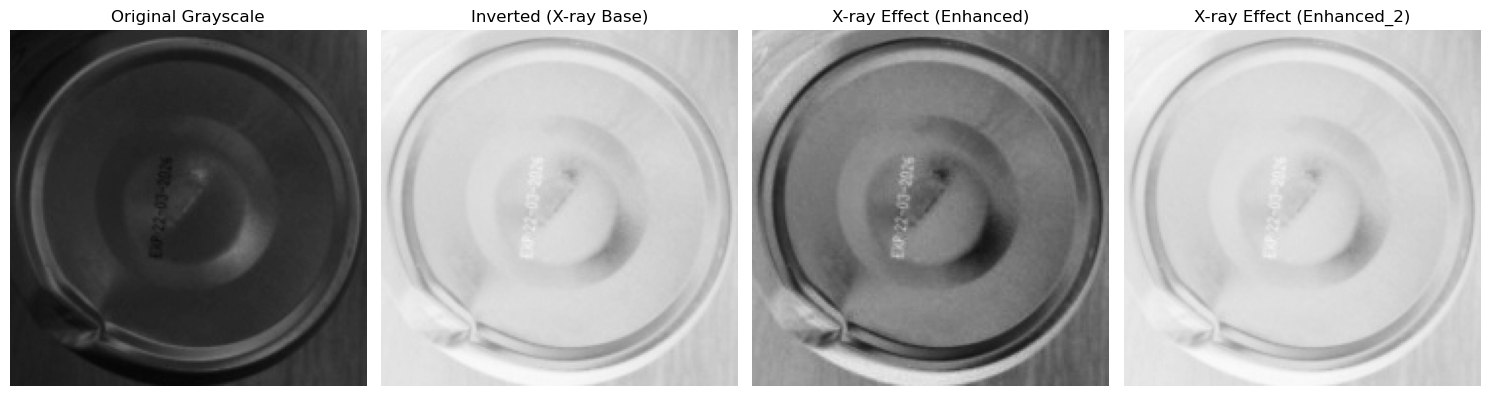

In [5]:
img = mpimg.imread('../data/processed/cropped_lids/p9_449_252_damaged.jpg')
gray = color.rgb2gray(img)

# Inverting grayscale values (X-ray style)
xray = 1 - gray  # Flip dark ↔ light

# Enhanceing contrast by applying gamma correction
xray_enhanced = np.clip(xray ** 4, 0, 1)   # xray ** 4 –- This is gamma correction. When each pixel value raised in xray to a power 
                                           # (in this case, 4), a non-linear contrast adjustment is done. 
                                           # Pixel values in xray range from 0.0 (black) to 1.0 (white).
                                           # Raising to the power of 4 (i.e., xray ** 4) darkens midtones even more and crushes bright values.

# Sometimes, after transformations like gamma correction, pixel values might go outside the valid range [0, 1]. For example:
# If transformation accidentally creates negative values → they’ll be forced to 0.
# If some pixels go above 1 → they'll be capped at 1.
# So np.clip(..., 0, 1) just keeps things safe and display-friendly for imshow.

xray_enhanced_2 = np.clip(xray ** 0.9, 0, 1)  

# Showing results
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(gray, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Grayscale')
axs[0].axis('off')

axs[1].imshow(xray, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Inverted (X-ray Base)')
axs[1].axis('off')

axs[2].imshow(xray_enhanced, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('X-ray Effect (Enhanced)')
axs[2].axis('off')

axs[3].imshow(xray_enhanced_2, cmap='gray', vmin=0, vmax=1)
axs[3].set_title('X-ray Effect (Enhanced_2)')
axs[3].axis('off')

plt.tight_layout()
plt.show()

We will use the xray_enhanced_2 effect.

# 1.9 Applying enhancements to the dataset

In [59]:
image_folder = '../data/processed/cropped_lids'  
save_folder = '../data/processed/Dataset_365'
img_size = (128, 128)

#### Applying Darkening effect

In [62]:
images = []
labels = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(image_folder, fname)

        # Labeling: 'intact' => 0, 'damaged' => 1
        if 'intact' in fname:
            label = 0
        elif 'damaged' in fname:
            label = 1
        else:
            continue  # skip unknown label types

        # Load as grayscale
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read {fname}, skipping.")
            continue

        # Resize image
        img = cv2.resize(img, img_size)

        # Apply darken effect (before normalization!)
        img = img.astype(np.float32) / 255.0  # convert to [0, 1]
        img *= 0.8                            # darken it
        img = np.clip(img, 0, 1)              # safety net

        images.append(img)
        labels.append(label)

print(f"Loaded and darkened {len(images)} images.")

Loaded and darkened 3718 images.


In [26]:
# Converting to NumPy array
X = np.array(images, dtype=np.float32)  
y = np.array(labels, dtype=np.uint8)

# Splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

Shapes: Train=(2602, 128, 128), Val=(558, 128, 128), Test=(558, 128, 128)


In [28]:
# Saveing 
os.makedirs(save_folder, exist_ok=True)

np.savez_compressed(f"{save_folder}/jarlid_train_dark_flip.npz", X=X_train, y=y_train)
np.savez_compressed(f"{save_folder}/jarlid_val_dark_flip.npz", X=X_val, y=y_val)
np.savez_compressed(f"{save_folder}/jarlid_test_dark_flip.npz", X=X_test, y=y_test)

print("Darkened datasets saved to:", save_folder)

Darkened datasets saved to: ../data/processed/Dataset_365


Data loaded. Shape: (2602, 128, 128), Labels shape: (2602,)
Class distribution: [1346 1256] (0 = intact, 1 = damaged)


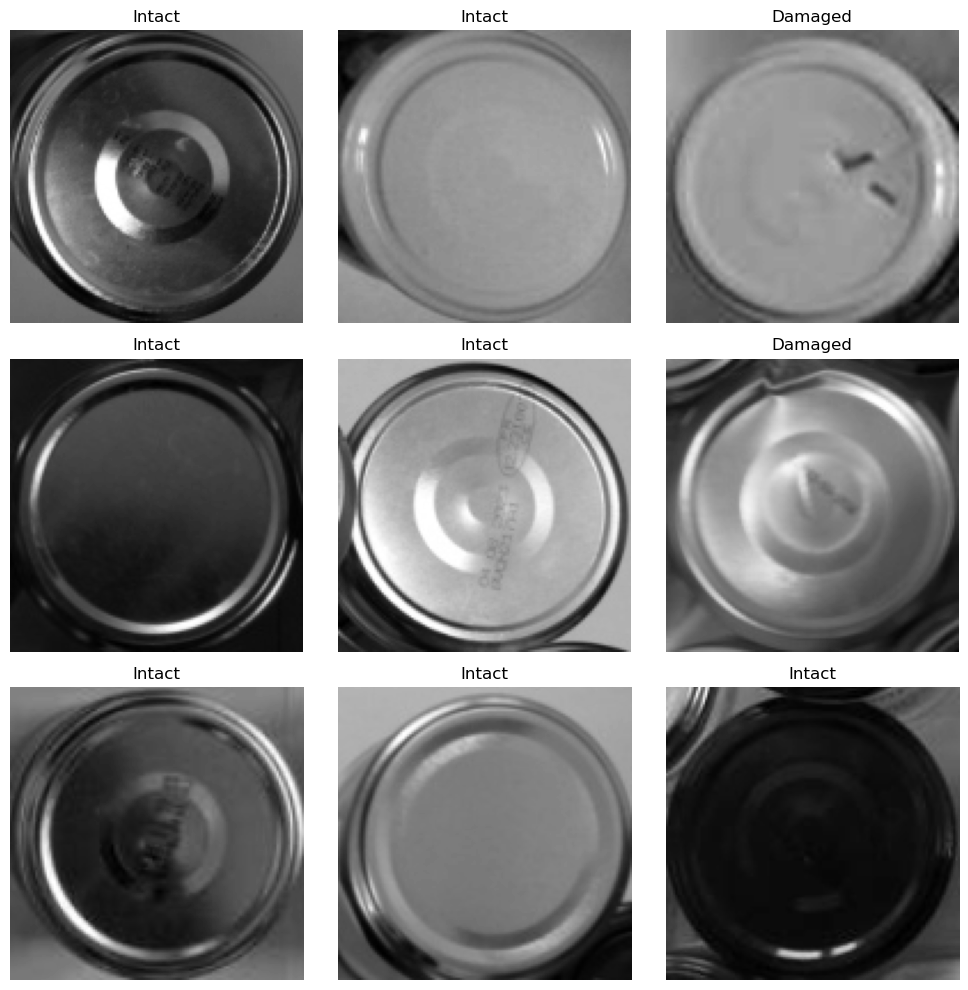

In [31]:
# Loading Darkened Dataset
data = np.load('../data/processed/Dataset_365/jarlid_train_dark_flip.npz')
X = data['X']
y = data['y']

print(f"Data loaded. Shape: {X.shape}, Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)} (0 = intact, 1 = damaged)")

# View Random Samples for sanity check
def show_random_images(X, y, n=9):
    indices = random.sample(range(len(X)), n)
    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        img = X[idx].squeeze()  # Removing channel dim (128, 128, 1) → (128, 128)
        label = y[idx]
        title = 'Intact' if label == 0 else 'Damaged'

        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(X, y)

We only applied the darkening effect to the original and flipped version of the image.

#### Applying Brightening effect

In [61]:
images = []
labels = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(image_folder, fname)

        # Labeling: 'intact' => 0, 'damaged' => 1
        if 'intact' in fname:
            label = 0
        elif 'damaged' in fname:
            label = 1
        else:
            continue  # skip unknown label types

        # Load as grayscale
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read {fname}, skipping.")
            continue

        # Resize image
        img = cv2.resize(img, img_size)

        # Applying brightening effect (before normalization!)
        img = img.astype(np.float32) / 255.0  # Convert to [0, 1]
        img *= 1.5                            # Brighten it
        img = np.clip(img, 0, 1)              # Safety net

        images.append(img)
        labels.append(label)

print(f"Loaded and Brightened {len(images)} images.")

Loaded and Brightened 3718 images.


In [33]:
# Converting to NumPy array
X = np.array(images, dtype=np.float32)  
y = np.array(labels, dtype=np.uint8)

# Splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

Shapes: Train=(2602, 128, 128), Val=(558, 128, 128), Test=(558, 128, 128)


In [34]:
# Saveing 
os.makedirs(save_folder, exist_ok=True)

np.savez_compressed(f"{save_folder}/jarlid_train_bright_flip.npz", X=X_train, y=y_train)
np.savez_compressed(f"{save_folder}/jarlid_val_bright_flip.npz", X=X_val, y=y_val)
np.savez_compressed(f"{save_folder}/jarlid_test_bright_flip.npz", X=X_test, y=y_test)

print("Brightened datasets saved to:", save_folder)

Brightened datasets saved to: ../data/processed/Dataset_365


Data loaded. Shape: (2602, 128, 128), Labels shape: (2602,)
Class distribution: [1346 1256] (0 = intact, 1 = damaged)


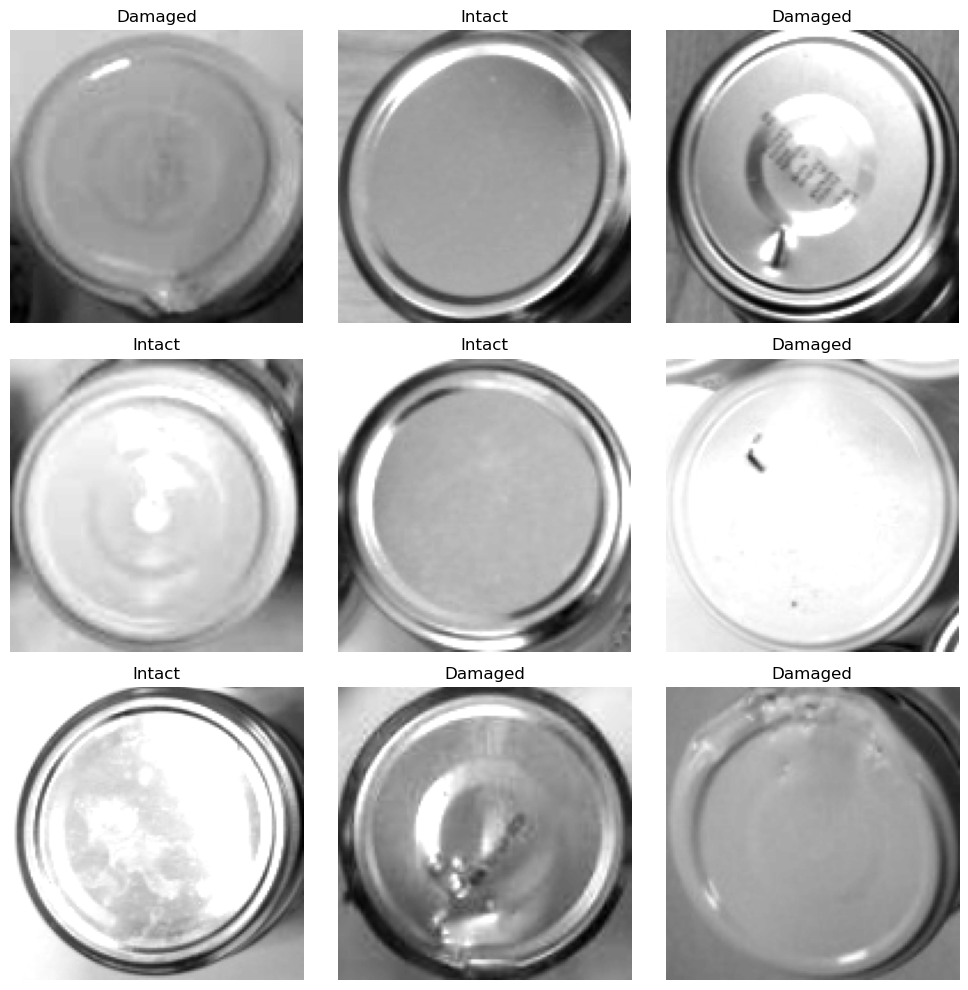

In [36]:
# Load Darkened Dataset
data = np.load('../data/processed/Dataset_365/jarlid_train_bright_flip.npz')
X = data['X']
y = data['y']

print(f"Data loaded. Shape: {X.shape}, Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)} (0 = intact, 1 = damaged)")

# View Random Samples for sanity check
def show_random_images(X, y, n=9):
    indices = random.sample(range(len(X)), n)
    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        img = X[idx].squeeze()  # Removing channel dim (128, 128, 1) → (128, 128)
        label = y[idx]
        title = 'Intact' if label == 0 else 'Damaged'

        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(X, y)

We only applied the brightening effect to the original and flipped version of the image.

#### Applying sharpening effect

In [60]:
images = []
labels = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(image_folder, fname)

        # Labeling: 'intact' => 0, 'damaged' => 1
        if 'intact' in fname:
            label = 0
        elif 'damaged' in fname:
            label = 1
        else:
            continue  # skip unknown label types

        # Load as grayscale
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read {fname}, skipping.")
            continue

        # Apply unsharp masking
        img_sharp = filters.unsharp_mask(img, radius=1, amount=3)

        # Rescale from float64 [0,1] to uint8 [0,255] before resizing
        img_sharp = (img_sharp * 255).astype(np.uint8)

        # Resize image
        img_resized = cv2.resize(img_sharp, img_size)

        # Add channel dimension: (128, 128) → (128, 128, 1)
        img_final = np.expand_dims(img_resized, axis=-1)

        images.append(img_final)
        labels.append(label)

print(f"Loaded and sharpened {len(images)} images.")

Loaded and sharpened 3718 images.


In [38]:
X = np.array(images, dtype=np.float32).squeeze() / 255.0  # Normalize to [0, 1]
y = np.array(labels, dtype=np.uint8)

# Splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

Shapes: Train=(2602, 128, 128), Val=(558, 128, 128), Test=(558, 128, 128)


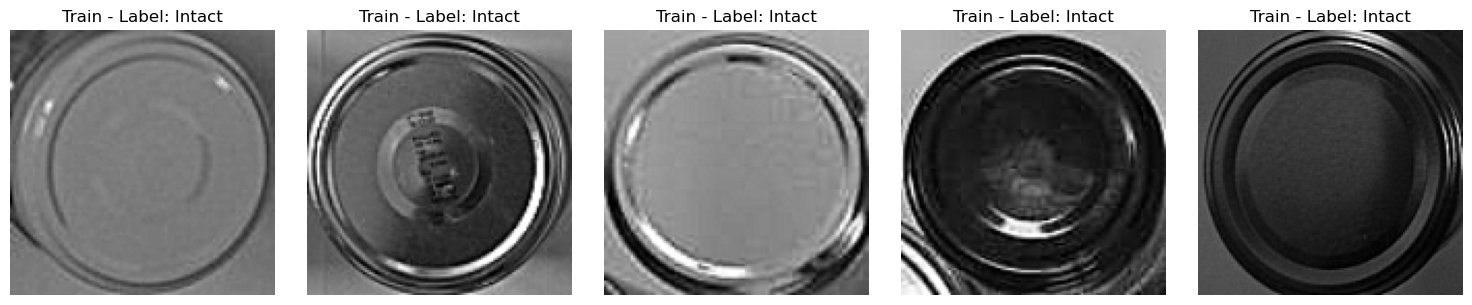

In [39]:
# Sanity Check: Visualizing Random Samples 
def show_random_images(X_data, y_data, title_prefix=''):
    indices = random.sample(range(len(X_data)), 5)
    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        img = X_data[idx].squeeze()  # shape: (128,128,1) → (128,128)
        label = y_data[idx]

        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title_prefix}Label: {'Intact' if label==0 else 'Damaged'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show a few from the sharpened training set
show_random_images(X_train, y_train, title_prefix="Train - ")

In [40]:
# Saving
os.makedirs(save_folder, exist_ok=True)

np.savez_compressed(f"{save_folder}/jarlid_train_sharpened_flip.npz", X=X_train, y=y_train)
np.savez_compressed(f"{save_folder}/jarlid_val_sharpened_flip.npz", X=X_val, y=y_val)
np.savez_compressed(f"{save_folder}/jarlid_test_sharpened_flip.npz", X=X_test, y=y_test)

print("Sharpened datasets saved to:", save_folder)

🎉 Sharpened datasets saved to: ../data/processed/Dataset_365


Sharpening effect is only applied to the original and flipped dataset.

#### Applying Sobel

We want to apply sobel to the original and 90 degree rotated dataset. So, we need to select only the images that are rotated 90 degrees.

shutil stands for shell utilities, and it provides high-level file operations, beyond what os does.

shutil is used for:
copy files or folders, move files or folders, delete folders (even non-empty ones), compress / extract files (zip/tar), get disk usage stats, create backup folders

In [44]:
# Source and destination folders
src_folder = "/mnt/d/Github repository/SpringboardCapstoneThree/data/processed/cropped_lids"
dst_folder = "/mnt/d/Github repository/SpringboardCapstoneThree/data/processed/rotated_90"

# Creates destination if it doesn't exist
os.makedirs(dst_folder, exist_ok=True)

# Loop through and copy files ending in "_rot90.jpg"
for fname in os.listdir(src_folder):
    if fname.endswith("_rot90.jpg"):
        src_path = os.path.join(src_folder, fname)
        dst_path = os.path.join(dst_folder, fname)
        shutil.copy2(src_path, dst_path)  # preserve metadata
        print(f"Copied: {fname}")

print("Done copying 90 degrees rotated images!")

Copied: p100_127_290_damaged_rot90.jpg
Copied: p100_146_137_damaged_rot90.jpg
Copied: p100_224_220_damaged_rot90.jpg
Copied: p100_244_76_intact_rot90.jpg
Copied: p100_249_334_intact_rot90.jpg
Copied: p100_335_190_damaged_rot90.jpg
Copied: p100_383_340_damaged_rot90.jpg
Copied: p100_403_80_damaged_rot90.jpg
Copied: p100_475_214_intact_rot90.jpg
Copied: p100_54_209_damaged_rot90.jpg
Copied: p101_146_242_damaged_rot90.jpg
Copied: p101_148_113_damaged_rot90.jpg
Copied: p101_247_12_intact_rot90.jpg
Copied: p101_266_188_damaged_rot90.jpg
Copied: p101_293_332_intact_rot90.jpg
Copied: p101_386_177_damaged_rot90.jpg
Copied: p101_395_77_damaged_rot90.jpg
Copied: p101_44_197_damaged_rot90.jpg
Copied: p101_44_344_damaged_rot90.jpg
Copied: p101_455_329_damaged_rot90.jpg
Copied: p101_533_194_intact_rot90.jpg
Copied: p102_135_342_damaged_rot90.jpg
Copied: p102_184_128_damaged_rot90.jpg
Copied: p102_272_342_damaged_rot90.jpg
Copied: p102_280_194_damaged_rot90.jpg
Copied: p102_303_7_intact_rot90.jpg
Co

In [45]:
images = []
labels = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(image_folder, fname)

        # Labeling: 'intact' => 0, 'damaged' => 1
        if 'intact' in fname:
            label = 0
        elif 'damaged' in fname:
            label = 1
        else:
            continue  # skipping unknown label types

        # Load as grayscale
        img_gray = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            print(f"Could not read {fname}, skipping.")
            continue

        # Resize grayscale image
        img_gray = cv2.resize(img_gray, img_size)

        # Applying Sobel Filter ====
        sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
        edge = cv2.magnitude(sobelx, sobely)
        edge = cv2.normalize(edge, None, 0, 255, cv2.NORM_MINMAX)
        edge = edge.astype(np.uint8)

        # Add channel dimension: (128, 128) → (128, 128, 1)
        edge = np.expand_dims(edge, axis=-1)

        images.append(edge)
        labels.append(label)

print(f"Loaded and edge-processed {len(images)} images.")

Loaded and edge-processed 3718 images.


In [46]:
X = np.array(images, dtype=np.float32).squeeze() / 255.0  # normalize to [0, 1]
y = np.array(labels, dtype=np.uint8)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

Shapes: Train=(2602, 128, 128), Val=(558, 128, 128), Test=(558, 128, 128)


In [47]:
# Saving
os.makedirs(save_folder, exist_ok=True)

np.savez_compressed(f"{save_folder}/jarlid_train_sobel_90.npz", X=X_train, y=y_train)
np.savez_compressed(f"{save_folder}/jarlid_val_sobel_90.npz", X=X_val, y=y_val)
np.savez_compressed(f"{save_folder}/jarlid_test_sobel_90.npz", X=X_test, y=y_test)

print("Edge-detected datasets saved to:", save_folder)

Edge-detected datasets saved to: ../data/processed/Dataset_365


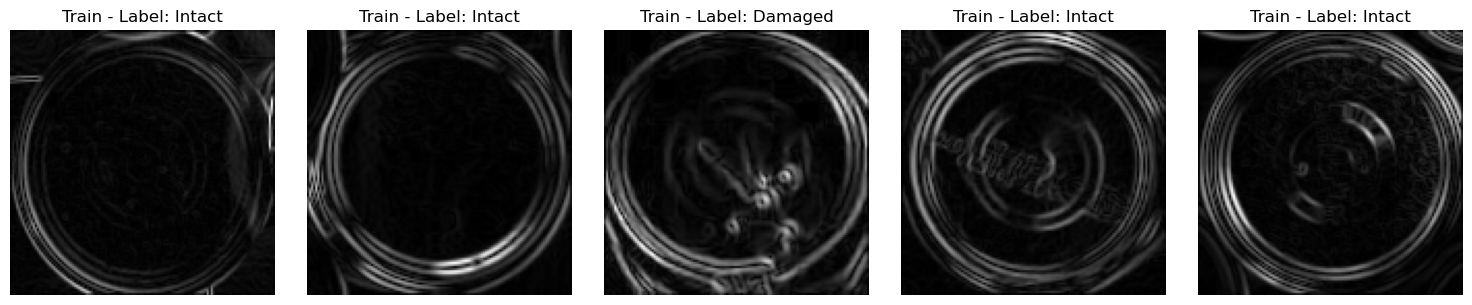

In [50]:
# Sanity Check: Visualizing Random Samples 
def show_random_images(X_data, y_data, title_prefix=''):
    indices = random.sample(range(len(X_data)), 5)
    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        img = X_data[idx].squeeze()  # shape: (128,128,1) → (128,128)
        label = y_data[idx]

        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title_prefix}Label: {'Intact' if label==0 else 'Damaged'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show a few from the sharpened training set
show_random_images(X_train, y_train, title_prefix="Train - ")

#### Applying X-ray effect

In [51]:
images = []
labels = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(image_folder, fname)

        # Labeling: 'intact' => 0, 'damaged' => 1
        if 'intact' in fname:
            label = 0
        elif 'damaged' in fname:
            label = 1
        else:
            continue  # Skipping unknown label types

        # Loading as grayscale
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read {fname}, skipping.")
            continue

        # Resizing image
        img = cv2.resize(img, img_size)

        # Applying X-ray enhancement 
        img_normalized = img.astype(np.float32) / 255.0  # normalize to [0, 1]
        xray = 1 - img_normalized
        xray_enhanced = np.clip(xray ** 0.9, 0, 1)

        images.append(xray_enhanced)
        labels.append(label)

print(f"Loaded {len(images)} X-ray enhanced images.")

Loaded 3718 X-ray enhanced images.


In [52]:
X = np.array(images, dtype=np.float32)  
y = np.array(labels, dtype=np.uint8)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

Shapes: Train=(2602, 128, 128), Val=(558, 128, 128), Test=(558, 128, 128)


In [53]:
os.makedirs(save_folder, exist_ok=True)

np.savez_compressed(f"{save_folder}/jarlid_train_xray_90.npz", X=X_train, y=y_train)
np.savez_compressed(f"{save_folder}/jarlid_val_xray_90.npz", X=X_val, y=y_val)
np.savez_compressed(f"{save_folder}/jarlid_test_xray_90.npz", X=X_test, y=y_test)

print("X-ray datasets saved to:", save_folder)

X-ray datasets saved to: ../data/processed/Dataset_365


#### Turning the augmented images to grayscale  

Now, we will turn the whole augmented set of images(rot35_left, rot35_right, rot_90, flip) into grayscale and save them as numpy array

In [54]:
images = []
labels = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(image_folder, fname)

        # Labeling: 'intact' => 0, 'damaged' => 1
        if 'intact' in fname:
            label = 0
        elif 'damaged' in fname:
            label = 1
        else:
            continue  # skipping unknown label types

        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read {fname}, skipping.")
            continue

        # Resizing to common shape
        img = cv2.resize(img, img_size)

        images.append(img)
        labels.append(label)

print(f"Loaded {len(images)} images.")

# Converting to NumPy 
X = np.array(images, dtype=np.float32) / 255.0  # normalizing to [0, 1]
y = np.array(labels, dtype=np.uint8)

# Splitting 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

Loaded 9295 images.
Shapes: Train=(6506, 128, 128), Val=(1394, 128, 128), Test=(1395, 128, 128)


In [55]:
# Saving
os.makedirs(save_folder, exist_ok=True)

np.savez_compressed(f"{save_folder}/jarlid_train_grayscale_aug.npz", X=X_train, y=y_train)
np.savez_compressed(f"{save_folder}/jarlid_val_grayscale_aug.npz", X=X_val, y=y_val)
np.savez_compressed(f"{save_folder}/jarlid_test_grayscale_aug.npz", X=X_test, y=y_test)

print("All datasets saved to:", save_folder)

All datasets saved to: ../data/processed/Dataset_365


# 1.10 Concatenating the datasets

In [56]:
# File paths 
augmentations = [
    "bright_flip",
    "dark_flip",
    "grayscale_aug",
    "sharpened_flip",
    "sobel_90",
    "xray_90"
]

base_path = "../data/processed/Dataset_365"
splits = ["train", "val", "test"]

In [57]:
for split in splits:
    X_list, y_list = [], []

    for aug in augmentations:
        file_path = f"{base_path}/jarlid_{split}_{aug}.npz"
        print(f"Loading {file_path}")
        data = np.load(file_path)
        X_list.append(data["X"])
        y_list.append(data["y"])

    # Stacking them
    X_merged = np.concatenate(X_list, axis=0)
    y_merged = np.concatenate(y_list, axis=0)

    save_path = f"{base_path}/merged_{split}.npz"
    np.savez_compressed(save_path, X=X_merged, y=y_merged)
    print(f"Saved {save_path}: X = {X_merged.shape}, y = {y_merged.shape}")

Loading ../data/processed/Dataset_365/jarlid_train_bright_flip.npz
Loading ../data/processed/Dataset_365/jarlid_train_dark_flip.npz
Loading ../data/processed/Dataset_365/jarlid_train_grayscale_aug.npz
Loading ../data/processed/Dataset_365/jarlid_train_sharpened_flip.npz
Loading ../data/processed/Dataset_365/jarlid_train_sobel_90.npz
Loading ../data/processed/Dataset_365/jarlid_train_xray_90.npz
Saved ../data/processed/Dataset_365/merged_train.npz: X = (19516, 128, 128), y = (19516,)
Loading ../data/processed/Dataset_365/jarlid_val_bright_flip.npz
Loading ../data/processed/Dataset_365/jarlid_val_dark_flip.npz
Loading ../data/processed/Dataset_365/jarlid_val_grayscale_aug.npz
Loading ../data/processed/Dataset_365/jarlid_val_sharpened_flip.npz
Loading ../data/processed/Dataset_365/jarlid_val_sobel_90.npz
Loading ../data/processed/Dataset_365/jarlid_val_xray_90.npz
Saved ../data/processed/Dataset_365/merged_val.npz: X = (4184, 128, 128), y = (4184,)
Loading ../data/processed/Dataset_365/ja

Now, we have a training set of 19516 images, test set of 4185 images and validation set of 4184 images.

Loaded merged_train: (19516, 128, 128), Labels: (19516,)
Label distribution: [10097  9419]


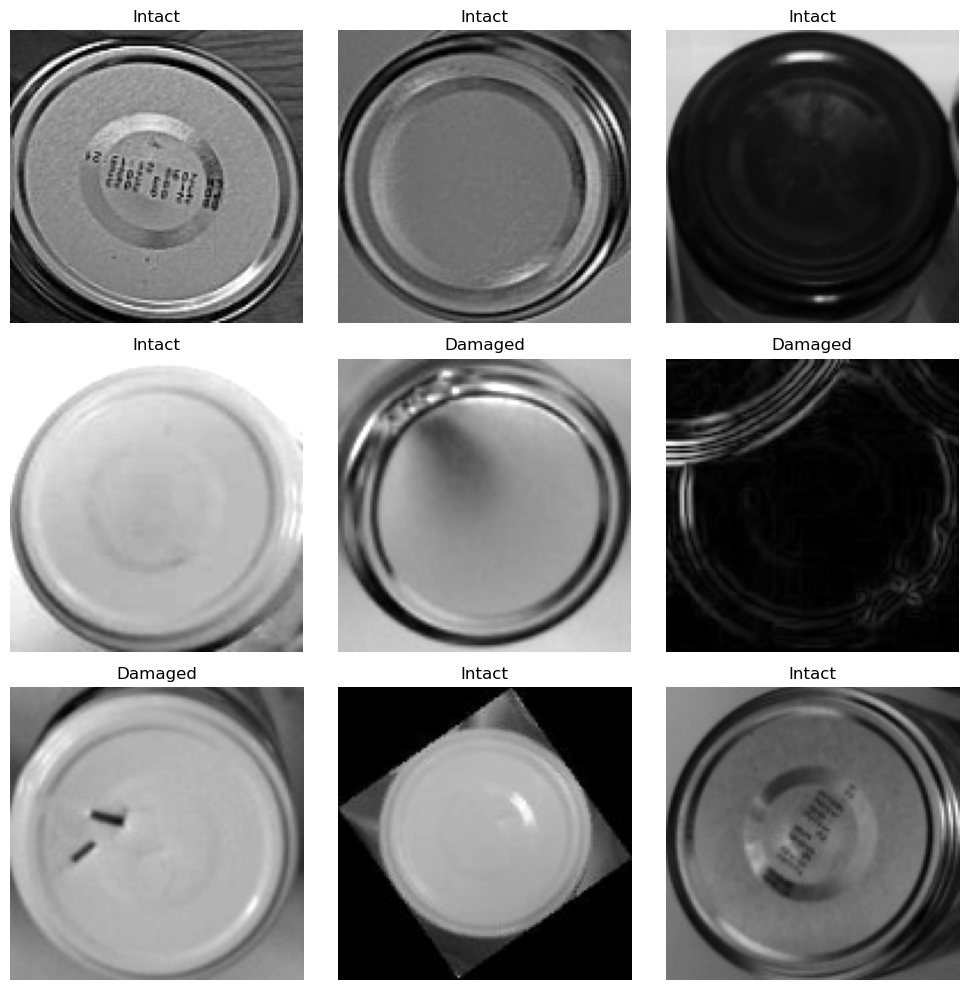

In [63]:
# Loading and Sanity Check 
data_train = np.load(f"{base_path}/merged_train.npz")
images_train = data_train['X']
labels_train = data_train['y']

print(f"Loaded merged_train: {images_train.shape}, Labels: {labels_train.shape}")
print(f"Label distribution: {np.bincount(labels_train)}")

# Showing Random Images 
def show_random_images(images, labels, n=9):
    indices = random.sample(range(len(images)), n)
    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        img = images[idx].squeeze()  # In case shape is (128, 128, 1)
        label = labels[idx]
        title = 'Intact' if label == 0 else 'Damaged'

        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(images_train, labels_train)